In [1]:
import pandas as pd
from pathlib import Path
from metapaths.tools.hetnet_file_processing import read_reactome
from metapaths.tools.processing import regularize_colnames, head, expand_col_on_char, combine_group_rows_on_char
from hetnet_ml.src import graph_tools as gt

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

load_dir = Path('../2_pipeline/00_download_data/out/').resolve()
network_dir = load_dir.parent.parent.joinpath('04_Incorporating_reactome/out')

In [2]:
all_nodes = gt.remove_colons(pd.read_csv(network_dir.joinpath('nodes_all.csv'), dtype=str))
edges = gt.remove_colons(pd.read_csv(network_dir.joinpath('edges.csv'), dtype=str))

In [3]:
all_node_ids = all_nodes['id'].values
new_nodes = []
new_edges = []

In [4]:
all_nodes.head(2)

,id,name,label,tree_numbers,drug_bank_ids,alt_disease_ids,gene_symbol,alt_gene_ids,bio_gridids,pharm_gkbids,uni_prot_ids,uniprot_id,mesh_ids,chebi_ids
0,MESH:C089250,(0.017ferrocene)amylose,Compound,D01.490.200/C089250|D02.691.550.200/C089250|D0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MESH:C114385,001-C8-NBD,Compound,D03.383.129.462.580/C114385|D12.644.456/C114385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# GO to Gene Relationships...

In [5]:
gene_term_edges = edges.query('abbv in {}'.format(['GeMF', 'GpoCC', 'GinBP']))

In [6]:
terms_per_gene = gene_term_edges.groupby(['start_id', 'abbv']).apply(len)
terms_per_gene = terms_per_gene.to_frame().reset_index().rename(columns={0: 'count'})

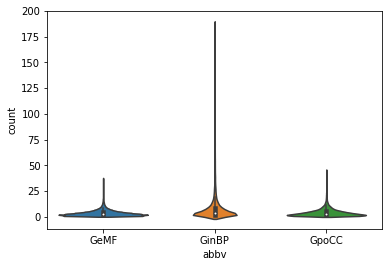

In [7]:
sns.violinplot(x='abbv', y='count', data=terms_per_gene)

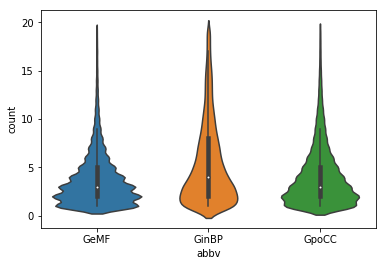

In [8]:
sns.violinplot(x='abbv', y='count', data=terms_per_gene[terms_per_gene['count'] < 20])

In [9]:
head(load_dir.joinpath('interpro2go.txt'), n_lines=6)

!date: 2019/03/22 10:12:05
!Mapping of InterPro entries to GO
!
InterPro:IPR000003 Retinoid X receptor/HNF4 > GO:DNA binding ; GO:0003677
InterPro:IPR000003 Retinoid X receptor/HNF4 > GO:steroid hormone receptor activity ; GO:0003707
InterPro:IPR000003 Retinoid X receptor/HNF4 > GO:zinc ion binding ; GO:0008270



In [10]:
test = pd.read_csv(load_dir.joinpath('interpro2go.txt'), sep='\ \>\ |\ ;\ ', engine='python',
                         comment='!', names=['pf_info', 'go_name', 'go_id'])
test

,pf_info,go_name,go_id
0,InterPro:IPR000003 Retinoid X receptor/HNF4,GO:DNA binding,GO:0003677
1,InterPro:IPR000003 Retinoid X receptor/HNF4,GO:steroid hormone receptor activity,GO:0003707
2,InterPro:IPR000003 Retinoid X receptor/HNF4,GO:zinc ion binding,GO:0008270
3,InterPro:IPR000003 Retinoid X receptor/HNF4,"GO:regulation of transcription, DNA-templated",GO:0006355
4,InterPro:IPR000003 Retinoid X receptor/HNF4,GO:nucleus,GO:0005634
5,"InterPro:IPR000006 Metallothionein, vertebrate",GO:metal ion binding,GO:0046872
6,InterPro:IPR000009 Protein phosphatase 2A regu...,GO:protein phosphatase regulator activity,GO:0019888
7,InterPro:IPR000009 Protein phosphatase 2A regu...,GO:protein phosphatase type 2A complex,GO:0000159
8,InterPro:IPR000010 Cystatin domain,GO:cysteine-type endopeptidase inhibitor activity,GO:0004869
9,InterPro:IPR000011 Ubiquitin/SUMO-activating e...,GO:ubiquitin-like modifier activating enzyme a...,GO:0008641


In [11]:
test = pd.read_csv(load_dir.joinpath('interpro2go.txt'), sep='\ ;\ ', engine='python',
                         comment='!', names=['pf_info', 'go_info', 'blech'])
test

,pf_info,go_info,blech
0,InterPro:IPR000003 Retinoid X receptor/HNF4 > ...,GO:0003677,NaN
1,InterPro:IPR000003 Retinoid X receptor/HNF4 > ...,GO:0003707,NaN
2,InterPro:IPR000003 Retinoid X receptor/HNF4 > ...,GO:0008270,NaN
3,InterPro:IPR000003 Retinoid X receptor/HNF4 > ...,GO:0006355,NaN
4,InterPro:IPR000003 Retinoid X receptor/HNF4 > ...,GO:0005634,NaN
5,"InterPro:IPR000006 Metallothionein, vertebrate...",GO:0046872,NaN
6,InterPro:IPR000009 Protein phosphatase 2A regu...,GO:0019888,NaN
7,InterPro:IPR000009 Protein phosphatase 2A regu...,GO:0000159,NaN
8,InterPro:IPR000010 Cystatin domain > GO:cystei...,GO:0004869,NaN
9,InterPro:IPR000011 Ubiquitin/SUMO-activating e...,GO:0008641,NaN


In [12]:
# Delimiters are garbage in this file... They are the first space on the line ' ', 
# then ' > ', and ' ; '. We can use a regex to ge the second and 3rd dels... but I'll have to manually 
# take care of the first... Whoever thoguht that was a good idea needs a talking to....

pfam_to_go = pd.read_csv(load_dir.joinpath('interpro2go.txt'), sep='\ \>\ |\ ;\ ', engine='python',
                         comment='!', names=['ip_info', 'go_name', 'go_id'])

# Split on the first space, and rejoin
pfam_to_go['ip_id'] = pfam_to_go['ip_info'].str.split(' ', expand=True)[0]
pfam_to_go['ip_name'] = pfam_to_go['ip_info'].apply(lambda i: ' '.join(i.split(' ')[1:]))

# Remove the dual-info line and return proper column order
pfam_to_go = pfam_to_go.drop([c for c in pfam_to_go if '_info' in c], axis=1)[['ip_id', 'ip_name', 'go_name', 'go_id']]

In [13]:
pfam_to_go

,ip_id,ip_name,go_name,go_id
0,InterPro:IPR000003,Retinoid X receptor/HNF4,GO:DNA binding,GO:0003677
1,InterPro:IPR000003,Retinoid X receptor/HNF4,GO:steroid hormone receptor activity,GO:0003707
2,InterPro:IPR000003,Retinoid X receptor/HNF4,GO:zinc ion binding,GO:0008270
3,InterPro:IPR000003,Retinoid X receptor/HNF4,"GO:regulation of transcription, DNA-templated",GO:0006355
4,InterPro:IPR000003,Retinoid X receptor/HNF4,GO:nucleus,GO:0005634
5,InterPro:IPR000006,"Metallothionein, vertebrate",GO:metal ion binding,GO:0046872
6,InterPro:IPR000009,Protein phosphatase 2A regulatory subunit PR55,GO:protein phosphatase regulator activity,GO:0019888
7,InterPro:IPR000009,Protein phosphatase 2A regulatory subunit PR55,GO:protein phosphatase type 2A complex,GO:0000159
8,InterPro:IPR000010,Cystatin domain,GO:cysteine-type endopeptidase inhibitor activity,GO:0004869
9,InterPro:IPR000011,Ubiquitin/SUMO-activating enzyme E1,GO:ubiquitin-like modifier activating enzyme a...,GO:0008641


In [14]:
go_ids = all_nodes['id'].str.startswith('GO:')
go_to_onto = all_nodes[go_ids].set_index('id')['label'].to_dict()
go_ids = all_nodes[go_ids]['id'].values

In [15]:
len(pfam_to_go), len(pfam_to_go.query('go_id in @go_ids'))

(34162, 34117)

In [16]:
pfam_to_go['go_ontology'] = pfam_to_go['go_id'].map(go_to_onto)

In [17]:
terms_per_fam = pfam_to_go.groupby(['ip_id', 'go_ontology']).apply(len)
terms_per_fam = terms_per_fam.to_frame().reset_index().rename(columns={0: 'count'})

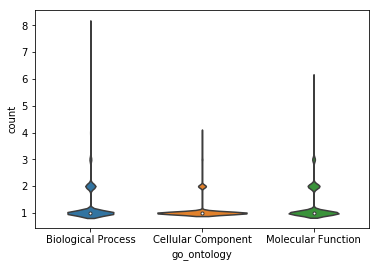

In [18]:
sns.violinplot(x='go_ontology', y='count', data=terms_per_fam);

In [21]:
gene_ids = all_nodes.query('label == "Gene"')['id'].unique()
len(gene_ids)

In [23]:
# Human gene edge index
idx = edges['organism_id'].str.contains('9606').fillna(False)

hgene_edge_ids = edges[idx][['start_id', 'end_id']].stack().unique()

hgenes = set(gene_ids) & set(hgene_edge_ids)
len(hgenes)

23329

In [24]:
import biothings_client

mg = biothings_client.get_client('gene')

In [25]:
qr = mg.getgenes(hgenes, fields='interpro.id')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-23329...done.


In [26]:
qr[0]

{'query': '5552',
 '_id': '5552',
 '_score': 20.973282,
 'interpro': {'id': 'IPR007455'}}

In [27]:
from collections import Counter
c = Counter([type(r.get('interpro')) for r in qr])
c

Counter({dict: 3018, list: 15632, NoneType: 4679})

In [28]:
gene_ids = []
interpro_ids = []

for result in qr:
    gene_id = result['query']
    interpro_info = result.get('interpro')
    
    if type(interpro_info) == dict:
        gene_ids.append(gene_id)
        interpro_ids.append(interpro_info.get('id'))
        
    elif type(interpro_info) == list:
        for xref in interpro_info:
            gene_ids.append(gene_id)
            interpro_ids.append(xref.get('id'))

gene_to_interpro = pd.DataFrame({'gene_id': gene_ids, 'interpro_id': interpro_ids})

In [29]:
gene_to_interpro.head(3)

,gene_id,interpro_id
0,5552,IPR007455
1,219983,IPR000276
2,219983,IPR000725


In [30]:
ipr_info = pd.read_csv(load_dir.joinpath('entry.list.tsv'), sep='\t')
ipr_info.columns = [c.lower() for c in ipr_info.columns]
ipr_info.head(2)

,entry_ac,entry_type,entry_name
0,IPR000126,Active_site,"Serine proteases, V8 family, serine active site"
1,IPR000138,Active_site,"Hydroxymethylglutaryl-CoA lyase, active site"


In [31]:
ipr_info['entry_type'].value_counts()

Family                    21769
Domain                    10637
Homologous_superfamily     3078
Conserved_site              688
Repeat                      316
Active_site                 132
Binding_site                 76
PTM                          17
Name: entry_type, dtype: int64

In [32]:
merge = pd.merge(gene_to_interpro, ipr_info, how='left', left_on='interpro_id', right_on='entry_ac')

In [33]:
merge.head(2)

,gene_id,interpro_id,entry_ac,entry_type,entry_name
0,5552,IPR007455,IPR007455,Family,Serglycin
1,219983,IPR000276,IPR000276,Family,"G protein-coupled receptor, rhodopsin-like"


In [34]:
merge['entry_type'].value_counts()

Domain                    29508
Homologous_superfamily    22174
Family                    17142
Conserved_site             3837
Repeat                     2178
Active_site                1024
Binding_site                839
PTM                         156
Name: entry_type, dtype: int64

In [35]:
pfam_to_go.head(2)

,ip_id,ip_name,go_name,go_id,go_ontology
0,InterPro:IPR000003,Retinoid X receptor/HNF4,GO:DNA binding,GO:0003677,Molecular Function
1,InterPro:IPR000003,Retinoid X receptor/HNF4,GO:steroid hormone receptor activity,GO:0003707,Molecular Function


In [36]:
ipr_info['ip_id'] = 'InterPro:' + ipr_info['entry_ac']
pfam_to_go_1 = pfam_to_go.merge(ipr_info, how='left', on='ip_id')
len(pfam_to_go_1)

34162

In [37]:
pfam_to_go_1['entry_type'].count()

34118

In [38]:
pfam_to_go_1['entry_type'].value_counts()

Family                    25416
Domain                     5755
Homologous_superfamily     1704
Conserved_site              896
Active_site                 139
Binding_site                106
Repeat                       92
PTM                          10
Name: entry_type, dtype: int64

In [39]:
gene_fams = merge.query('entry_type == "Family"')
fams_per_gene = gene_fams.groupby('gene_id').apply(len).to_frame()
fams_per_gene['metric'] = 'Fams per gene'
genes_per_fam = gene_fams.groupby('entry_ac').apply(len).to_frame()
genes_per_fam['metric'] = 'Genes per fam'

counts = pd.concat([genes_per_fam, fams_per_gene]).rename(columns={0: 'counts'})

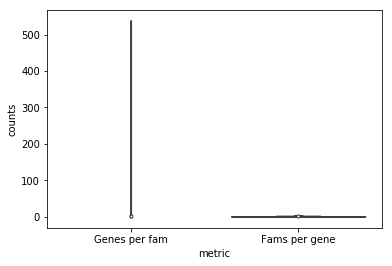

In [40]:
sns.violinplot(x='metric', y='counts', data=counts)

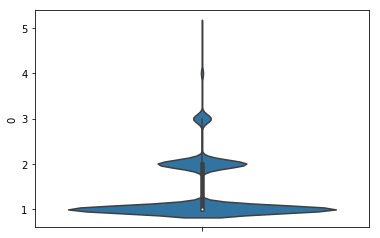

In [41]:
sns.violinplot(y=fams_per_gene[0])

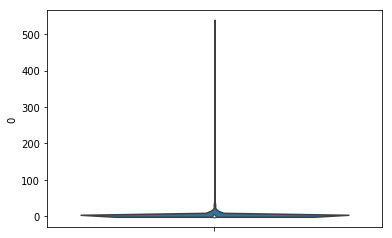

In [42]:
sns.violinplot(y=genes_per_fam[0])

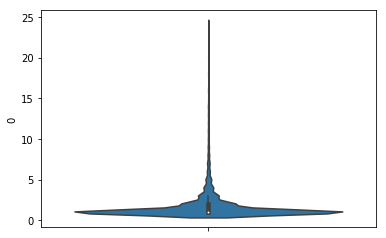

In [43]:
sns.violinplot(y=genes_per_fam[genes_per_fam[0] < 25][0])

In [44]:
fam_terms = ipr_info.query('entry_type == "Family"')
len(fam_terms)

21769

In [45]:
fam_nodes = fam_terms[['ip_id', 'entry_name']].copy()
fam_nodes.columns = [c.split('_')[-1] for c in fam_nodes.columns]
fam_nodes['label'] = 'Protein Family'
fam_nodes.head(2)

,id,name,label
11533,InterPro:IPR000003,Retinoid X receptor/HNF4,Protein Family
11534,InterPro:IPR000006,"Metallothionein, vertebrate",Protein Family


In [46]:
edge_map = {'Molecular Function': 'enables_PFeMF',
            'Biological Process': 'involved_in_PFinBP',
            'Cellular Component': 'part_of_PFpoCC'}

fam_ids = fam_nodes['id'].unique()
edges_fam_to_go = pfam_to_go.query('ip_id in @fam_ids').copy()
edges_fam_to_go['type'] = edges_fam_to_go['go_ontology'].map(edge_map)

edges_fam_to_go = edges_fam_to_go[['ip_id', 'go_id', 'type']]
edges_fam_to_go = edges_fam_to_go.rename(columns={'ip_id': 'start_id', 'go_id': 'end_id'})
edges_fam_to_go.head(2)

,start_id,end_id,type
0,InterPro:IPR000003,GO:0003677,enables_PFeMF
1,InterPro:IPR000003,GO:0003707,enables_PFeMF


In [47]:
len(edges_fam_to_go)

25416

In [48]:
gene_to_interpro['interpro_id'] = 'InterPro:' + gene_to_interpro['interpro_id']
edges_gene_to_fam = gene_to_interpro.query('interpro_id in @fam_ids').copy()
edges_gene_to_fam = edges_gene_to_fam.rename(columns={'gene_id': 'start_id', 'interpro_id': 'end_id'})
edges_gene_to_fam['type'] = 'part_of_GpoPF'
edges_gene_to_fam.head(2)

,start_id,end_id,type
0,5552,InterPro:IPR007455,part_of_GpoPF
1,219983,InterPro:IPR000276,part_of_GpoPF


In [49]:
len(gene_to_interpro)

77364

# Putting it all together

In [50]:
new_nodes_df = fam_nodes
new_edges_df = pd.concat([edges_fam_to_go, edges_gene_to_fam], sort=False)

In [51]:
new_nodes_df.head(2)

,id,name,label
11533,InterPro:IPR000003,Retinoid X receptor/HNF4,Protein Family
11534,InterPro:IPR000006,"Metallothionein, vertebrate",Protein Family


In [52]:
new_edges_df.head(2)

,start_id,end_id,type
0,InterPro:IPR000003,GO:0003677,enables_PFeMF
1,InterPro:IPR000003,GO:0003707,enables_PFeMF


In [53]:
new_edges_df['type'].value_counts()

part_of_GpoPF         17142
involved_in_PFinBP    10773
enables_PFeMF          9485
part_of_PFpoCC         5123
Name: type, dtype: int64

In [54]:
print('Total number of new edges: {:,}'.format(len(new_edges_df)))
print('Number of unique new edges: {:,}'.format(len(new_edges_df.drop_duplicates(subset=['start_id', 'end_id', 'type']))))

Total number of new edges: 42,558
Number of unique new edges: 42,558


In [55]:
all_node_ids = set(all_nodes['id']) | set(new_nodes_df['id'])

print(len(new_edges_df))
new_edges_df_filt = new_edges_df.query('start_id in @all_node_ids and end_id in @all_node_ids').copy()
print(len(new_edges_df_filt))

42558
42523


In [56]:
len(new_edges_df) - len(new_edges_df_filt)

35

In [57]:
new_edges_df.query('start_id not in @all_node_ids or end_id not in @all_node_ids').head(5)

,start_id,end_id,type
1594,InterPro:IPR000983,GO:0008565,NaN
2686,InterPro:IPR001639,GO:0008565,NaN
4105,InterPro:IPR002416,GO:0008565,NaN
4282,InterPro:IPR002528,GO:0015238,NaN
5314,InterPro:IPR003369,GO:0008565,NaN


GO terms that aren't in the network.... Drop them...

In [58]:
all_nodes_out = pd.concat([all_nodes, new_nodes_df], sort=False)
all_nodes_out.head(2)

,id,name,label,tree_numbers,drug_bank_ids,alt_disease_ids,gene_symbol,alt_gene_ids,bio_gridids,pharm_gkbids,uni_prot_ids,uniprot_id,mesh_ids,chebi_ids
0,MESH:C089250,(0.017ferrocene)amylose,Compound,D01.490.200/C089250|D02.691.550.200/C089250|D0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MESH:C114385,001-C8-NBD,Compound,D03.383.129.462.580/C114385|D12.644.456/C114385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
new_edges_df_filt['abbv'] = new_edges_df_filt['type'].apply(lambda s: s.split('_')[-1])
all_edges = pd.concat([edges, new_edges_df_filt], sort=False)
all_edges.head(2)

,start_id,end_id,type,parent_ixn,pub_med_ids,organism_id,abbv,direct_evidence,corrected_pvalue,inference_gene_symbol,qualifier,db_reference,evidence_code,with_or_from,date,assigned_by,experiments,support_type
0,MESH:C000121,4313,decreases_activity_CdaG,decreases^activity,25899827,9606,CdaG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MESH:C000121,4313,decreases_expression_CdeG,decreases^expression,25899827,9606,CdeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
len(all_node_ids) == len(all_nodes_out)

True

In [61]:
all_edge_ids = all_edges[['start_id', 'end_id']].stack()
filt_nodes_out = all_nodes_out.query('id in @all_edge_ids')
len(filt_nodes_out)

126088

# Save to Disk

In [62]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')
// hack to get the filename for this notebook

<IPython.core.display.Javascript object>

In [63]:
out_dir = Path('../2_pipeline/').joinpath(nb_name.split('.')[0]).joinpath('out').resolve()
out_dir.mkdir(parents=True, exist_ok=True)

In [64]:
gt.add_colons(new_nodes_df, id_name='identifier').to_csv(out_dir.joinpath('new_nodes.csv'), index=False)
gt.add_colons(new_edges_df).to_csv(out_dir.joinpath('new_edges.csv'), index=False)

In [65]:
gt.add_colons(all_nodes_out, id_name='identifier').to_csv(out_dir.joinpath('nodes_all.csv'), index=False)
gt.add_colons(filt_nodes_out, id_name='identifier').to_csv(out_dir.joinpath('nodes_filt.csv'), index=False)

gt.add_colons(all_edges).to_csv(out_dir.joinpath('edges.csv'), index=False)